# Visualize mean maximum SWE accummulation at the HRU-level
Needs: 
- Catchment shapefile with HRU delineation
- SUMMA output `scalarSWE`

In [1]:
# modules
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line:
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [13]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'mean_annual_swe_per_hru_bowAtBanff.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Get shapefile location from control file

In [14]:
# HM catchment shapefile path & name
hm_catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
hm_catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

# Specify default path if needed
if hm_catchment_path == 'default':
    hm_catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    hm_catchment_path = Path(hm_catchment_path) # make sure a user-specified path is a Path()

In [15]:
# Find the GRU and HRU identifiers
hm_gruid = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')
hm_hruid = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### Get the shapefile with elevation for comparison purposes

In [16]:
# Intersection of catchment shapefile and DEM; path & name
elev_catchment_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
elev_catchment_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

# Specify default path if needed
if elev_catchment_path == 'default':
    elev_catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    elev_catchment_path = Path(elev_catchment_path) # make sure a user-specified path is a Path()

#### Find the location of the simulations

In [17]:
# SUMMA simulation path
summa_output_path = read_from_control(controlFolder/controlFile,'experiment_output_summa')
experiment_id = read_from_control(controlFolder/controlFile,'experiment_id')

# Specify default path if needed
if summa_output_path == 'default':
    summa_output_path = make_default_path('simulations/' + experiment_id + '/SUMMA') # outputs a Path()
else:
    summa_output_path = Path(summa_output_path) # make sure a user-specified path is a Path()

In [18]:
# Specify the output file name and variable of interest
summa_output_name = experiment_id + '_day.nc'
plot_var = 'scalarSWE'

#### Load the shape and data

In [19]:
# catchment shapefile
shp = gpd.read_file(hm_catchment_path/hm_catchment_name)

In [20]:
# SUMMA simulations
sim = xr.open_dataset(summa_output_path/summa_output_name)

In [21]:
# catchment with DEM
shp_elev = gpd.read_file(elev_catchment_path/elev_catchment_name)

#### Add a water year definition

In [34]:
# Define in which month the water year starts
water_year_start = 'Oct' # Assumed to be on the 1st of the month

In [44]:
# Convert month the number 
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
start_month = months.index(water_year_start) + 1 # add 1 to account for 0-based indexing in Python

In [87]:
# Add a water year variable for grouping
sim['water_year'] = sim['time'].dt.year # set initial year

In [88]:
# Overwrite the year for months that are part of the water year that started last calendar year
sim['water_year'].loc[sim['time'].dt.month < start_month] -= 1

#### Preprocessing

In [129]:
# Select only complete water years
complete_water_years = (sim['water_year'] > min(sim['water_year'])) & (sim['water_year'] < max(sim['water_year']))

In [141]:
# Find the mean maximum water-year SWE per HRU
plot_dat = sim[plot_var].sel(time=complete_water_years).groupby(sim['water_year'].sel(time=complete_water_years)).max(dim='time').mean(dim='water_year')

In [142]:
# Match the accummulated values to the correct HRU IDs in the shapefile
hru_ids_shp = shp[hm_hruid] # hru order in shapefile
shp['plot_var'] = plot_dat.sel(hru=hru_ids_shp.values)

In [111]:
# Create a shapefile with only GRU boundaries for overlay
hm_grus_only = shp[[hm_gruid,'geometry']] # keep only the gruId and geometry
hm_grus_only = hm_grus_only.dissolve(by=hm_gruid) # Dissolve HRU delineation

In [112]:
# Get the units of our plotting variable
units = sim[plot_var].units

#### Figure

In [113]:
# Set a colormap
cmap_swe  = 'cividis_r'
cmap_elev = 'terrain'

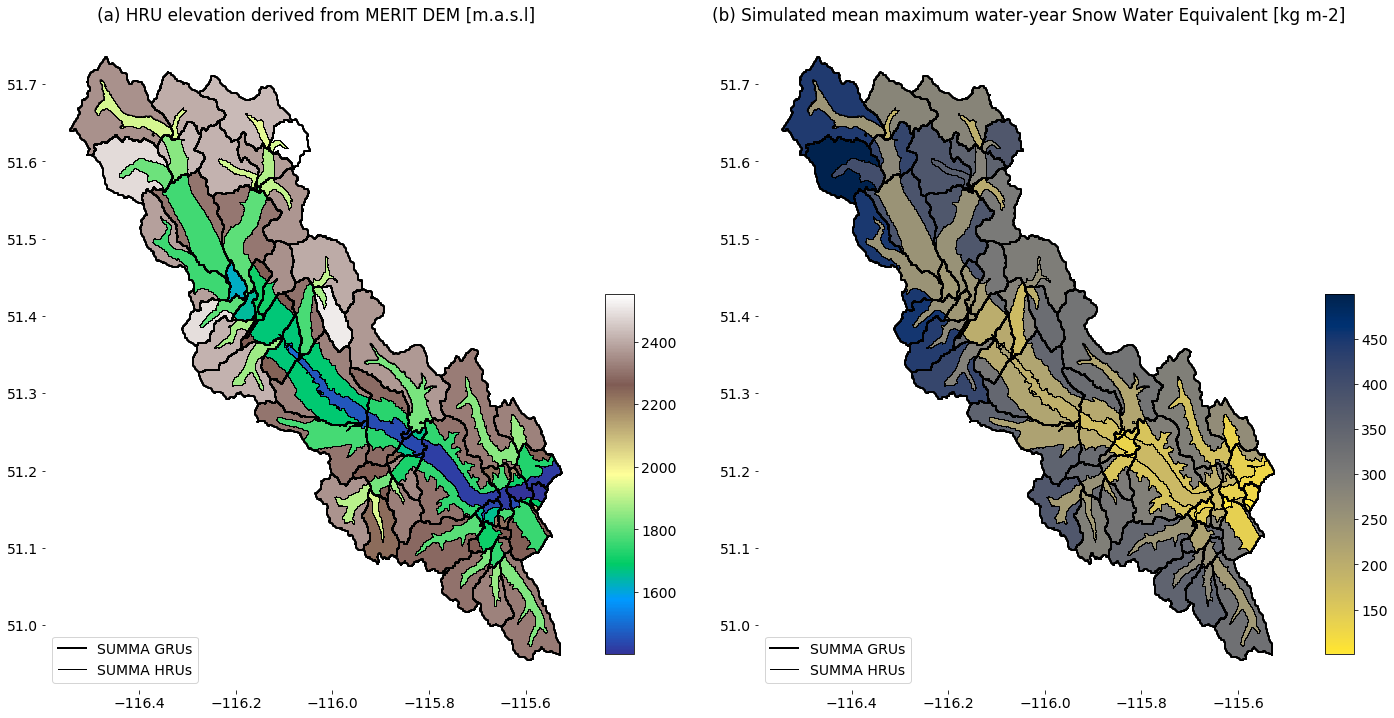

In [143]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

# --- elevation
axId = 0

# Data
shp_elev.plot(ax=axs[axId], column='elev_mean',edgecolor='k', cmap = cmap_elev, legend=False)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.1, 0.02, 0.5])
vmin,vmax = shp_elev['elev_mean'].min(),shp_elev['elev_mean'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_elev, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) HRU elevation derived from MERIT DEM [m.a.s.l]');
axs[axId].set_frame_on(False)

# --- SWE
axId = 1

# Data
shp.plot(ax=axs[axId], column='plot_var',edgecolor='k', cmap = cmap_swe, legend=False);
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Custom colorbar
cax = fig.add_axes([0.96, 0.1, 0.02, 0.5])
vmin,vmax = shp['plot_var'].min(),shp['plot_var'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_swe, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

# Chart junk
axs[axId].set_title('(b) Simulated mean maximum water-year Snow Water Equivalent [{}]'.format(units));
axs[axId].set_frame_on(False)

# Save 
plt.savefig(fig_path/fig_name, bbox_inches='tight')

#### test

In [21]:
import time
from IPython import display

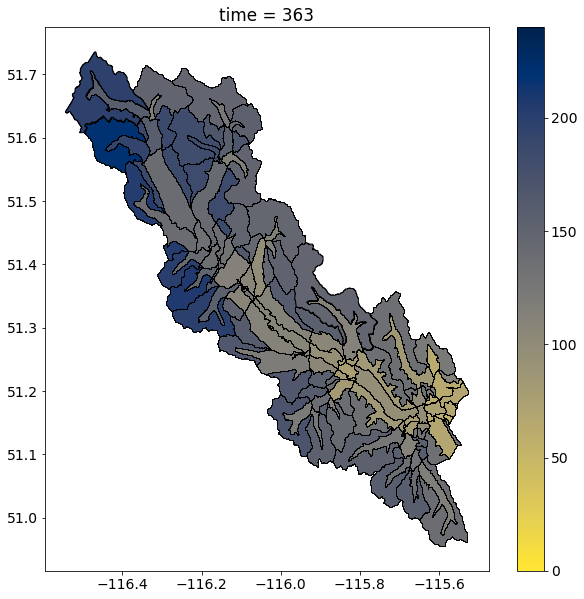

In [22]:
for tt in range(0,364):
    
    plt.close();
    
    # get swe
    shp['plot_var'] = sim['scalarSWE'].isel(time=tt).sel(hru=hru_ids_shp.values)
    
    # plot with fixed limits
    shp.plot(figsize=(10,10),column='plot_var',edgecolor='k', cmap = cmap_swe, legend=True, vmin=0, vmax=240);
    plt.title('time = {}'.format(tt));
    
    # live updates
    display.display(plt.gcf());
    display.clear_output(wait=True);
    time.sleep(.1);
    #input("Press Enter to continue...")
    

In [58]:
# timestep outputs
summa_output_name_timestep = experiment_id + '_timestep.nc'
sim_ts = xr.open_dataset(summa_output_path/summa_output_name_timestep)
sim_ts

<xarray.Dataset>
Dimensions:              (gru: 51, hru: 118, time: 8760)
Coordinates:
  * time                 (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00.000013440
  * hru                  (hru) int64 48 97 118 1 49 100 2 ... 45 94 46 95 47 96
  * gru                  (gru) int64 71028585 71028597 ... 71032422 71032440
Data variables:
    pptrate              (time, hru) float64 ...
    airtemp              (time, hru) float64 ...
    latitude             (hru) float64 ...
    longitude            (hru) float64 ...
    averageRoutedRunoff  (time, gru) float64 ...
    hruId                (hru) int64 ...
    gruId                (gru) int64 ...
Attributes:
    summaVersion:     
    buildTime:        Fri Feb  5 12:45:27 CST 2021
    gitBranch:        devCopernicus-0-g2d09d05
    gitHash:          2d09d057167e00b45d758d0ceae9de4d5fba0112
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    soilStress:       NoahType
    stomResist:       BallBerry
    num_method:       itertive
    fDerivMeth:       analytic
    LAI_method:       monTable
    f_Richards:       mixdform
    groundwatr:       bigBuckt
    hc_profile:       constant
    bcUpprTdyn:       nrg_flux
    bcLowrTdyn:       zeroFlux
    bcUpprSoiH:       liq_flux
    bcLowrSoiH:       drainage
    veg_traits:       Raupach_BLM1994
    canopyEmis:       difTrans
    snowIncept:       lightSnow
    windPrfile:       logBelowCanopy
    astability:       louisinv
    canopySrad:       BeersLaw
    alb_method:       conDecay
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       timeDlay
    notPopulatedYet:  notPopulatedYet

In [59]:
# create daily average temperature
daily_temp = sim_ts['airtemp'].resample(time='1D').mean()
daily_temp

<xarray.DataArray 'airtemp' (time: 365, hru: 118)>
array([[244.15365961, 241.42945982, 239.57974979, ..., 241.26905076,
        244.04177385, 241.06809426],
       [250.51543278, 247.79123299, 245.94152296, ..., 245.88334354,
        248.19110399, 245.31427384],
       [249.4792561 , 246.75505631, 244.90534628, ..., 244.37431224,
        246.49292665, 243.64755885],
       ...,
       [264.34036615, 261.61616636, 259.76645633, ..., 261.83875799,
        264.55739122, 261.59215037],
       [262.33830621, 259.61410642, 257.7643964 , ..., 259.5233461 ,
        262.4224107 , 259.38546118],
       [263.70830387, 260.98410408, 259.13439406, ..., 260.26884858,
        262.99029451, 260.00694275]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * hru      (hru) int64 48 97 118 1 49 100 2 50 101 ... 44 93 45 94 46 95 47 96

In [61]:
daily_temp.max()

<xarray.DataArray 'airtemp' ()>
array(294.13250222)

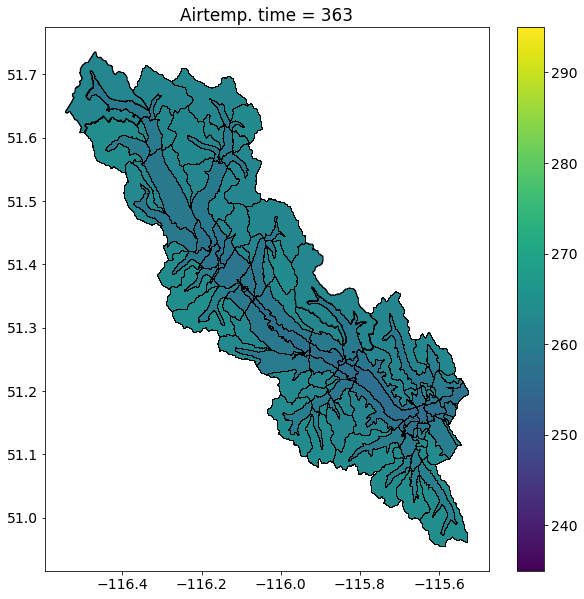

In [64]:
for tt in range(0,364):
    
    plt.close();
    
    # get swe
    shp['plot_var'] = daily_temp.isel(time=tt).sel(hru=hru_ids_shp.values)
    
    # plot with fixed limits
    shp.plot(figsize=(10,10),column='plot_var',edgecolor='k', legend=True, vmin=235, vmax=295);
    plt.title('Airtemp. time = {}'.format(tt));
    
    # live updates
    display.display(plt.gcf());
    display.clear_output(wait=True);
    time.sleep(.1);